In [258]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_rows', None)     # show all rows
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', None)        # no fixed width wrapping
pd.set_option('display.max_colwidth', None) # show full cell content

In [259]:
def peek_df(df, target_col=None):
    print("="*40)
    print("HEAD OF DATAFRAME")
    print("="*40)
    if df.shape[1] > 5:
        print(df.iloc[:, :5].head())
    else:
        print(df.head())

    print("="*40)
    print("SHAPE OF DATAFRAME")
    print("="*40)
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")

    print("="*40)
    print("INFO")
    print("="*40)
    df.info()
    print()

    print("="*40)
    print("MISSING VALUES")
    print("="*40)
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if not missing.empty:
        missing_percent = (missing / len(df)) * 100
        missing_df = pd.DataFrame({
            "Missing Values": missing,
            "Percent": missing_percent.round(2)
        })
        print(missing_df, "\n")
    else:
        print("No missing values.\n")

    print("="*40)
    print("DESCRIPTIVE STATS (NUMERIC)")
    print("="*40)
    print(df.describe(), "\n")

    print("="*40)
    print("DESCRIPTIVE STATS (CATEGORICAL)")
    print("="*40)
    categorical_cols = df.select_dtypes(include='object').columns
    if len(categorical_cols) > 0:
        print(df[categorical_cols].describe(), "\n")
    else:
        print("No categorical (object) columns to describe.\n")

    print("="*40)
    print("UNIQUE VALUES")
    print("="*40)
    for col in df.columns:
        if df[col].nunique(dropna=True) <= 20:
            print(f"{col}: {df[col].unique()}")

    if target_col:
        print("="*40)
        print(f"TARGET COLUMN DISTRIBUTION: {target_col}")
        print("="*40)
        print(df[target_col].value_counts(), "\n")

        sns.countplot(x=target_col, data=df)
        plt.title(f"Countplot of '{target_col}'")
        plt.show()

        if df.shape[1] <= 35:
            print("="*40)
            print("CORRELATION HEATMAP (NUMERIC FEATURES)")
            print("="*40)
            numeric_df = df.select_dtypes(include=['number'])
            sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm", fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.show()

In [260]:
# Read the training and test datasets
df_raw_train = pd.read_csv('../datasets/vaastav/2024_2025/fpl_data_all_gw.csv')

In [261]:
def pick_gw(df, gw):
    common_cols = [col for col in df.columns if not col.startswith('gw')]
    gw_cols = [col for col in df.columns if col.startswith(f'gw{gw}_')]
    selected_cols = common_cols + gw_cols
    return df[selected_cols].copy()

In [262]:
# Specify the game week number
gw_num = 1
target_col = f'gw{gw_num}_total_points'
df_gw = pick_gw(df_raw_train, gw_num)

HEAD OF DATAFRAME
   element                          name     team position  gw1_xP
0        1         Fábio Ferreira Vieira  Arsenal      MID     2.3
1        2     Gabriel Fernando de Jesus  Arsenal      FWD     3.2
2        3  Gabriel dos Santos Magalhães  Arsenal      DEF     4.2
3        4                   Kai Havertz  Arsenal      FWD     3.5
4        5                     Karl Hein  Arsenal       GK     0.0
SHAPE OF DATAFRAME
Rows: 615, Columns: 34

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   element                         615 non-null    int64  
 1   name                            615 non-null    object 
 2   team                            615 non-null    object 
 3   position                        615 non-null    object 
 4   gw1_xP                          615 non-null    float64


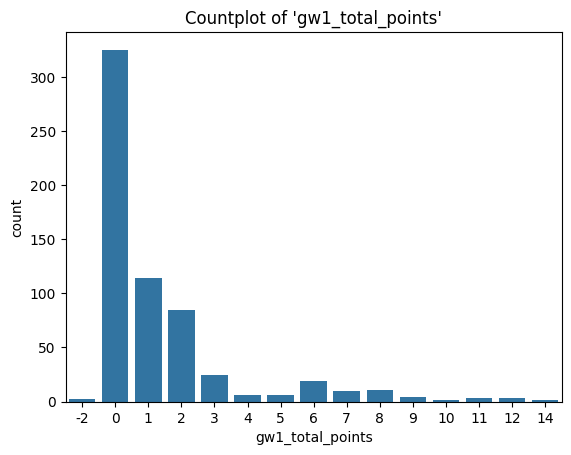

CORRELATION HEATMAP (NUMERIC FEATURES)


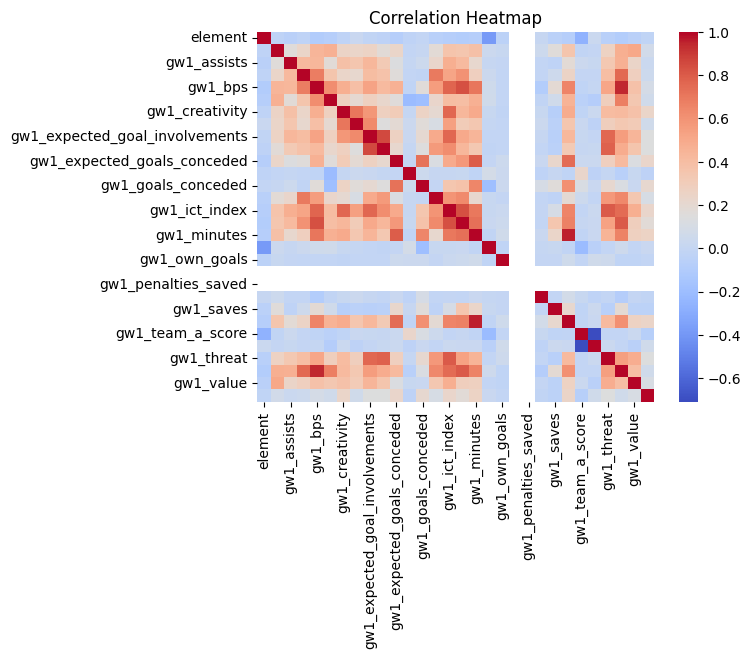

In [263]:
peek_df(df_gw, target_col)

In [264]:
# drop a few columns
df_gw.drop(columns=['element', 'name', 'team'], inplace=True)
gw_cols_to_drop = ['fixture', 'opponent_team', 'value']
df_gw.drop(columns=[f'gw{gw_num}_{col}' for col in gw_cols_to_drop], inplace=True)

In [265]:
df_gw.columns

Index(['position', 'gw1_xP', 'gw1_assists', 'gw1_bonus', 'gw1_bps',
       'gw1_clean_sheets', 'gw1_creativity', 'gw1_expected_assists',
       'gw1_expected_goal_involvements', 'gw1_expected_goals',
       'gw1_expected_goals_conceded', 'gw1_goals_conceded', 'gw1_goals_scored',
       'gw1_ict_index', 'gw1_influence', 'gw1_minutes', 'gw1_own_goals',
       'gw1_penalties_missed', 'gw1_penalties_saved', 'gw1_red_cards',
       'gw1_saves', 'gw1_starts', 'gw1_team_a_score', 'gw1_team_h_score',
       'gw1_threat', 'gw1_total_points', 'gw1_was_home', 'gw1_yellow_cards'],
      dtype='object')

In [266]:
# one-hot encode position
position_encoder = OneHotEncoder(sparse_output=False, dtype=int)
pos_onehot = position_encoder.fit_transform(df_gw[['position']])
pos_onehot_df = pd.DataFrame(pos_onehot, columns=position_encoder.get_feature_names_out(['position']))

# Align indices before concatenation
pos_onehot_df.index = df_gw.index

# Drop the original column and concatenate
df_gw = pd.concat([df_gw.drop(columns=['position']), pos_onehot_df], axis=1)

HEAD OF DATAFRAME
   gw1_xP  gw1_assists  gw1_bonus  gw1_bps  gw1_clean_sheets
0     2.3            0          0        0                 0
1     3.2            0          0        1                 0
2     4.2            0          0       22                 1
3     3.5            1          3       48                 1
4     0.0            0          0        0                 0
SHAPE OF DATAFRAME
Rows: 615, Columns: 31

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gw1_xP                          615 non-null    float64
 1   gw1_assists                     615 non-null    int64  
 2   gw1_bonus                       615 non-null    int64  
 3   gw1_bps                         615 non-null    int64  
 4   gw1_clean_sheets                615 non-null    int64  
 5   gw1_creativity                 

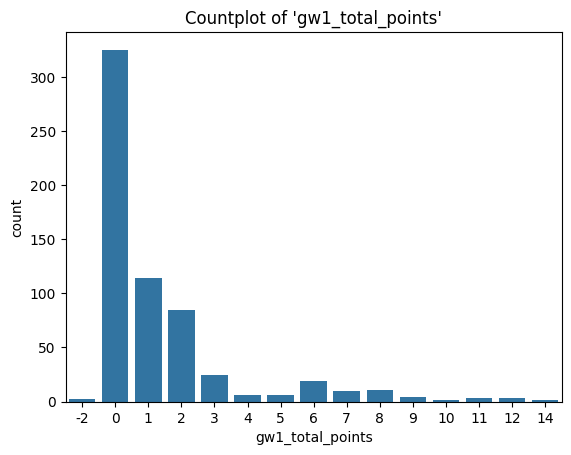

CORRELATION HEATMAP (NUMERIC FEATURES)


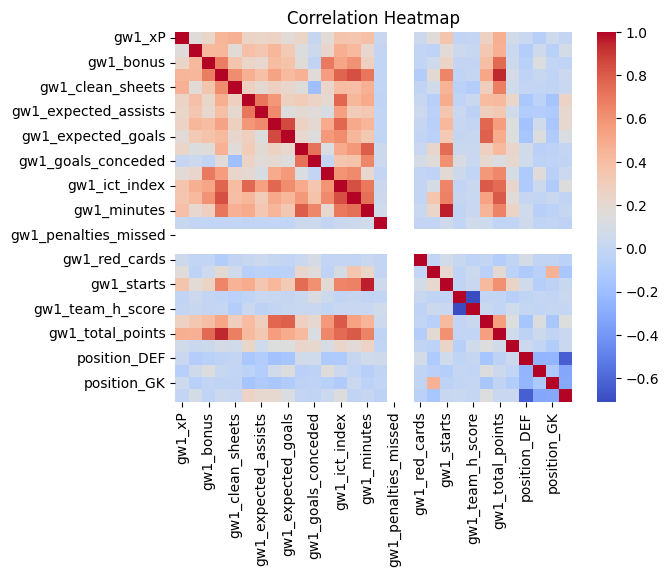

In [267]:
peek_df(df_gw, target_col)

In [268]:
# split target from features
X = df_gw.drop(columns=[target_col])
X.insert(0, 'Bias', 1)  # add bias term

# one-hot encode target
y = df_gw[[target_col]]

# Assuming X already has the bias column added and y is a DataFrame or Series
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=8)

In [269]:
X.shape

(615, 31)

In [270]:
y.shape

(615, 1)

In [271]:
# initialize
num_iterations = 1000
alpha = 0.0001
theta = np.array([0]*(X.shape[1]))

In [272]:
# batch gradient descent
history_bgd = np.zeros((num_iterations + 1, X.shape[1]))
history_bgd[0,:] = theta

In [273]:
theta.shape

(31,)

In [274]:
history_bgd.shape

(1001, 31)

In [275]:
# Perform batch gradient descent
for iter in range(num_iterations):
    prediction = X @ theta
    error = prediction - y.values.ravel()
    gradient = (X.T @ error / len(y)).to_numpy()
    theta = theta - alpha * gradient
    history_bgd[iter+1, :] = theta
    print(f"Iteration {iter+1}/{num_iterations} completed.")
    print(f"Theta: {theta}\n")

Iteration 1/1000 completed.
Theta: [0.00013170731707317076 0.00032448780487804896 2.2601626016260165e-05
 9.398373983739837e-05 0.002665691056910569 6.227642276422765e-05
 0.0015771219512195121 1.09089430894309e-05 3.160325203252032e-05
 2.0694308943089422e-05 0.00012162276422764218 6.829268292682928e-05
 3.0081300813008135e-05 0.0006384715447154468 0.0029518373983739845
 0.0100869918699187 0.0 0.0 0.0 -6.504065040650407e-07
 3.8699186991869915e-05 0.0001134959349593496 0.00015902439024390245
 0.0001143089430894309 0.0018547967479674798 6.487804878048781e-05
 1.1382113821138211e-05 3.934959349593496e-05 1.83739837398374e-05
 1.2845528455284554e-05 6.113821138211382e-05]

Iteration 2/1000 completed.
Theta: [0.00022602361822517548 0.0005707487742277239 4.193079977690793e-05
 0.00017655116070703947 0.004805567427745148 0.0001134710328821839
 0.002726425341095738 1.9123680510770652e-05 5.649535778046414e-05
 3.7371677269693485e-05 0.0002029556248310465 0.00010345801675465928
 5.65593739747

In [276]:
theta.shape

(31,)

In [277]:
y.values.shape

(615, 1)

In [278]:
def compute_cost(X, y, theta):
    theta = np.array(theta).flatten()  # in case it's a column vector
    return 0.5*sum((X@theta - y.values.ravel())**2)/ len(y)    # MSE

def plot_costs(X, y, history):
    # Compute cost at each step
    costs = [compute_cost(X, y, history[i]) for i in range(len(history))]

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(costs, label='Cost', color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Cost (MSE)")
    plt.title("Cost vs Iteration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

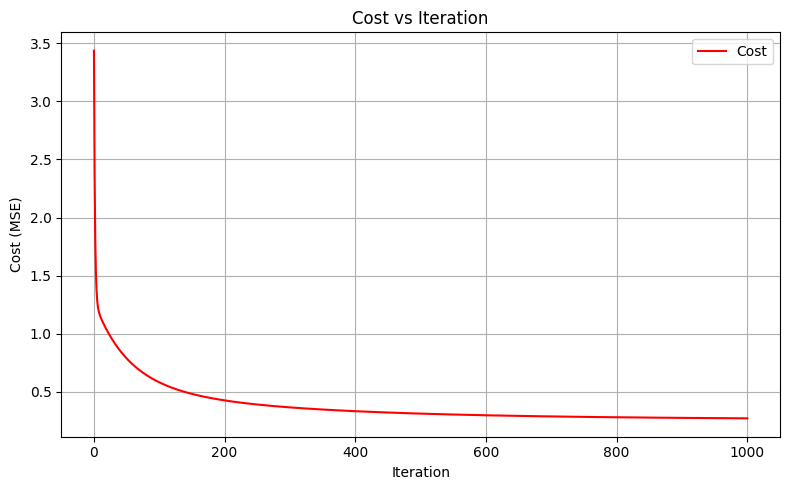

In [279]:
plot_costs(X, y, history_bgd)

In [280]:
y.shape

(615, 1)